In [1]:
# import python libraries
import geopandas as gpd
import pandas as pd
import regionmask
import xarray as xr
import os
from glob import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

In [2]:
# set working directory
os.chdir('/Users/marianawebb/Documents/Nevada/SW_CASC')
# os.getcwd()

# set user-specified variable values
start_yr = 1979
end_yr = 2023

huc_size = "huc8" # must be a string e.g.('huc8')

save_folder = "data/gridmet"

In [3]:
# get southwest HUCs
huclist = sorted(glob('data/HUCs/sw_'+huc_size+'_clean.shp'))
print(huclist[0])

# read in HUC8 shapefiles
huc_shp = gpd.read_file(huclist[0])
huc_shp[huc_size] = huc_shp[huc_size].astype('int64')
# huc_shp.plot()

# get lat long boundaries for SW watersheds, used to crop raster data
# huc_shp.total_bounds
huc_lat = [float(huc_shp.total_bounds[1]), float(huc_shp.total_bounds[3])]
huc_lon = [float(huc_shp.total_bounds[0]), float(huc_shp.total_bounds[2])]

data/HUCs/sw_huc8_clean.shp


In [4]:
# get list of netcdf files (in this case, there is just one)
nclist = sorted(glob('data/gridmet/raw/*'))
print(nclist)

# read in netCDF as an xarray object
df = xr.open_mfdataset(nclist).sel(
    lon=slice(huc_lon[0], huc_lon[1]),
    lat=slice(huc_lat[1], huc_lat[0]))

# number of days each year spent in severe or extreme drought (PDSI <= -3)
# df['drought'] = xr.where(df['pdsi'] <= -2, 1, 0)

# create watersheds mask
# huc_mask = regionmask.mask_3D_geopandas(huc_shp, df, numbers = huc_size, overlap = True)

['data/gridmet/raw/gridmet_trend_precip_in.slope.tif', 'data/gridmet/raw/gridmet_trend_temp_F.slope.tif']


ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [6]:
# for loop for reading in and processing basin averages annually
for yr in np.arange(start_yr, end_yr+1):
    print(yr)
    
    # checking if year already processed
    processed_files = glob("data/PDSI/watershed_processed/*.csv")
    processed_yr = [x[-8:-4] for x in processed_files]
    
    if str(yr) in processed_yr:
        print(str(yr)+" already processed")
        
    else:
        # subset dataframe to year of interest
        sub_df = df.sel(day=slice(str(yr), str(yr+1)))

        # mask data to watershed extents
        masked_df = sub_df.where(huc_mask)

        # calculate cummulative and mean values for each watershed for each day
        print("calculating watershed means...")
        pdsi_means = masked_df.groupby("region").mean(['lat', 'lon'])
        # pdsi_means = pdsi_means.unstack()
        print("converting to dask dataframe...")
        means_df = pdsi_means.to_dask_dataframe()
        means_df = means_df.rename(columns=dict(zip(means_df.columns[3:], means_df.columns[3:] + '_mean')))

        # compute dask
        print("computing dask...")
        with ProgressBar():
          compute_df = means_df.compute() #full_df.compute()

        # export data table 
        print("exporting...")
        export_location = save_folder+'/watershed_processed/pdsi_watershed_mean_'+str(yr)+'.csv'
        compute_df.to_csv(export_location, index = True)
        print('exported csv')
  
 

1979
1979 already processed
1980
1980 already processed
1981
1981 already processed
1982
1982 already processed
1983
1983 already processed
1984
1984 already processed
1985
1985 already processed
1986
1986 already processed
1987
1987 already processed
1988
1988 already processed
1989
1989 already processed
1990
1990 already processed
1991
1991 already processed
1992
1992 already processed
1993
1993 already processed
1994
1994 already processed
1995
1995 already processed
1996
1996 already processed
1997
1997 already processed
1998
1998 already processed
1999
1999 already processed
2000
2000 already processed
2001
2001 already processed
2002
2002 already processed
2003
2003 already processed
2004
2004 already processed
2005
2005 already processed
2006
2006 already processed
2007
2007 already processed
2008
2008 already processed
2009
2009 already processed
2010
2010 already processed
2011
2011 already processed
2012
2012 already processed
2013
2013 already processed
2014
2014 already pr

In [7]:
# read in csv files to create dataframe of all values
csv_files = sorted(glob('data/PDSI/watershed_processed/*'))

df_list = []
for f in csv_files:
    csv = pd.read_csv(f)
    df_list.append(csv)

# concatenate all data frames into one
pdsi_df = pd.concat(df_list)
pdsi_df = pdsi_df.drop(pdsi_df.columns[[0,3]], axis=1) #remove extra columns
pdsi_df = pdsi_df.rename(columns={"region":huc_size})

In [11]:
# calculate drought occurrence

# new variable saying if at least 10% of the watershed is in moderate to extreme drought
pdsi_df["drought_10per"] = np.where(pdsi_df['drought_mean'] >= 0.1, 1, 0) 
# new variable saying if the average of the watershed is in moderate to extreme drought
pdsi_df["drought"] = np.where(pdsi_df['pdsi_mean'] <= -2, 1, 0)
# calculate mean values across time
pdsi_df_mean = pdsi_df.groupby(huc_size).mean(numeric_only = True)

#export dataframe as csv
pdsi_df.to_csv('data/PDSI/pdsi_watershed_processed.csv', index=True)  

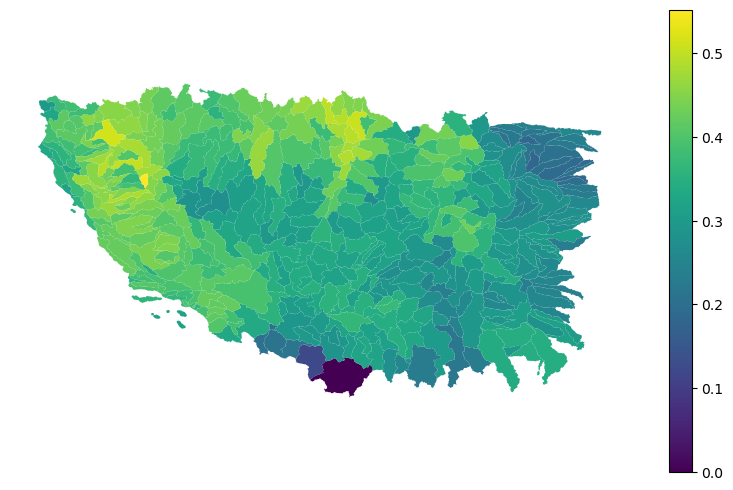

In [13]:
# plot drought occurrence across watersheds
pdsi_shp = huc_shp.merge(pdsi_df_mean, on=huc_size)

# create the plot
fig, ax = plt.subplots(figsize = (10,6))

# plot the data 
pdsi_shp.reset_index().plot(column = 'drought', ax=ax, legend=True)

# Set plot axis to equal ratio
ax.set_axis_off()
plt.axis('equal');